In [1]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.animation import FuncAnimation
from tqdm import tqdm
import glob
from scipy.optimize import curve_fit
from scipy.linalg import expm
from colorsys import hls_to_rgb
import pickle, os, sys
from pathlib import Path

sys.path.append("../common")
sys.path.insert(0, "../pyMMF")
import pyMMF
from functions import get_disk_mask
from functions import get_color_map, colorize, load_complex32, stack_correlation


In [2]:
FIBER = "Draka_GRIN"
# FIBER = "TL_GRIN2"
DATA_PATH = Path("../Data") / FIBER
# path to save images
IMAGE_FOLDER = Path("../images") / FIBER
os.makedirs(IMAGE_FOLDER, exist_ok=True)


def file_path(file_name):
    full_path = str(DATA_PATH / file_name)
    print(f">> file path: {full_path}")
    return full_path


def image_path(file_name):
    full_path = str(IMAGE_FOLDER / file_name)
    print(f">> image path: {full_path}")
    return full_path

In [3]:
def get_rotation_matrix(m, l, alpha):
    """rotation matrix in the OAM basis"""
    return np.diag(np.exp(1j * np.array(m) * alpha))


In [4]:
REF_SIZE = 22
TICK_SIZE = REF_SIZE
LEGEND_SIZE = REF_SIZE - 4
LABEL_SIZE = REF_SIZE + 2
TITLE_SIZE = REF_SIZE + 2
SMALL_TITLE_SIZE = REF_SIZE
TINY_TITLE_SIZE = REF_SIZE - 4
SUP_TITLE_SIZE = REF_SIZE + 6


# I. Load data

### A. Load parameters of the fiber and the experiment

In [5]:
with open(file_path("param.pkl"), "rb") as file:
    param = pickle.load(file, encoding="latin1")


# number of pixels in each axis in the input plane (DMD)
N_in = param["fiber"]["inpoints"]
# number of pixels in each axis in the output plane (camera)
N_out = param["fiber"]["onpoints"]
# 
# angles of rotation of the input wavefronts
angles = param["RME"]["angles"]
n_a = param["RME"]["n_angles"]
# number of random input wavefronts
n_rnd = param["RME"]["n_rnd"]
nv_max = param["RME"]["nv_max"]

# number of operatoirs
n_op = param["RME"]["n_op"]
# number of the first modes of each operator sent to the DMD
n_rm = param["RME"]["n_rm"]
n_angles_for_corr = param["RME"]["n_ang_corr"]


# load parameters associated with the shrinked data files
with open(file_path("param_small.pkl"), "rb") as file:
    param = pickle.load(file, encoding="latin1")

# number of deformation values stored in the demo
# (the actual full dataset has 30 deformation values)
n_deform = param["n_deform"]

# deformation indices used in the demo
deformation_indices = param["deformation_indices"]

# deformation values
Delta_x = param["Delta_x"]


>> file path: ../Data/Draka_GRIN/param.pkl
>> file path: ../Data/Draka_GRIN/param_small.pkl


### B. Load the measured output fields corresponding to rotated inputs for different deformations 

**load and concatenate the measurements for random input at different levels of deformation**

In [6]:
filepaths = glob.glob(file_path("Ys_rnd_small_p1*.npz"))
arrays = []
for filepath in filepaths:
    data = np.load(filepath)
    arr = load_complex32(filename=filepath)
    arrays.append(arr)
Ys_rnd = np.stack(arrays, axis=0)
# Ys_rnd = Ys_rnd.reshape(list(Ys_rnd.shape[:-1])+[N_out]*2)


>> file path: ../Data/Draka_GRIN/Ys_rnd_small_p1*.npz


**load measurements for the RME operator channels**

In [7]:
Ys_rm = load_complex32(filename=file_path("Ys_rm_small.npz"))

>> file path: ../Data/Draka_GRIN/Ys_rm_small.npz


### C. Load the modes

In [16]:
modes = np.load(os.path.join(DATA_PATH, "modes.npz"))
Mout = modes["modes_out"].astype(np.complex64)
m = modes["m"]
l = modes["l"]
N_out = int(np.sqrt(Mout.shape[1]))


In [21]:
Ys_rm_mode = np.einsum('dmaix, xn -> dmain', Ys_rm, Mout.transpose().conjugate())
# Ys_rm = Ys_rm.reshape(list(Ys_rm.shape[:-1])+[N_out]*2)

### D. Load the TMs in the mode basis

In [22]:
TMs = np.load(os.path.join(DATA_PATH, "TMs_mode.npy")).astype(np.complex64)
nmodes = TMs.shape[-1]
# TMs = TMs_mode[:, :nmodes, :]


## II. Computation of angular memory effect correlation for random input wavefronts

### A. Show some output fields
Note that the field are already rotated back, i.e. $Y=\mathbf{R}(-\theta)\mathbf{T}\mathbf{R}(\theta) E^\text{rnd}_\text{in}$

This means that images associated with different angles $\theta$ correspond to the same mask rotated in input by $\theta$ and then rotated in output by angles $-\theta$. Then, for a perfect RME, all images would be identical for different values of $\theta$.

../common/functions.py:41: RuntimeWarning: divide by zero encountered in true_divide
  l = 1.0 / (1.0 + r**beta) if theme == "white" else 1.0 - 1.0 / (1.0 + r**beta)


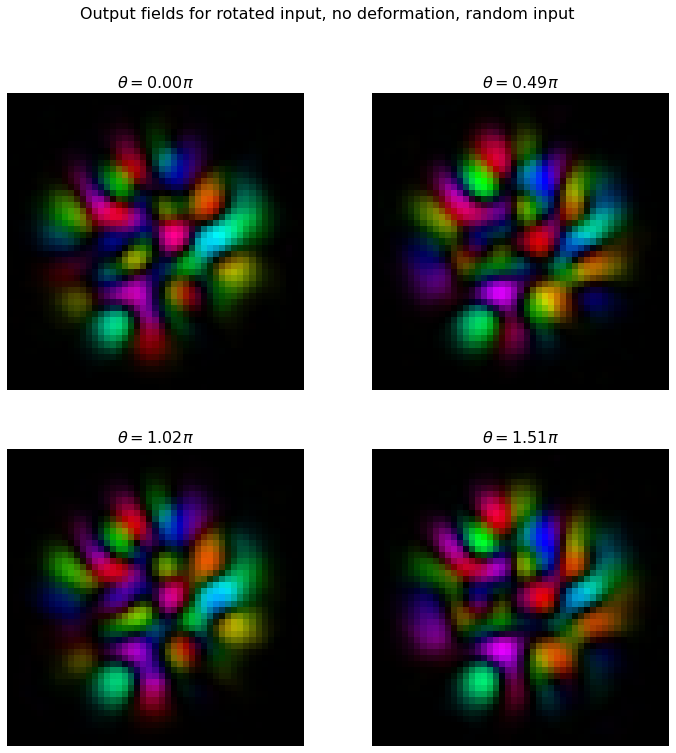

In [23]:
def get_ind_angle(angle):
    # return the index of the angle in the array of angles
    return np.argmin(np.abs(angles - angle))


angle2show = [0, np.pi / 2, np.pi, 3 * np.pi / 2]
ind_step = 0
ind_rnd = 0

# plot the output wavefronts
plt.figure(figsize=(12, 12))
# plot each output wavefront
for i, angle in enumerate(angle2show):
    plt.subplot(2, 2, i + 1)
    ind_angle = get_ind_angle(angle)
    actual_angle = angles[ind_angle]
    field = Ys_rnd[ind_step, ind_angle, ind_rnd].reshape([N_out] * 2)
    plt.imshow(colorize(field))
    plt.axis("off")
    plt.title(f"$\\theta={actual_angle/np.pi:.2f}\pi$", fontsize=16)
    plt.suptitle(
        "Output fields for rotated input, no deformation, random input", fontsize=16
    )


In [43]:
T = TMs[0]
def get_RME_operator(T,angle):
    R = get_rotation_matrix(m, l, alpha = angle)
    return T.transpose().conjugate()@R.transpose().conjugate()@T@R



In [44]:
T = TMs[0]
angles_for_op = np.linspace(0, 2*np.pi, 8, endpoint=False)
O = np.sum([get_RME_operator(T,a) for a in angles_for_op], axis = 0)

In [45]:
u,s,v = np.linalg.svd(O)

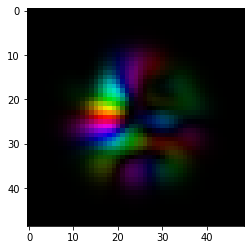

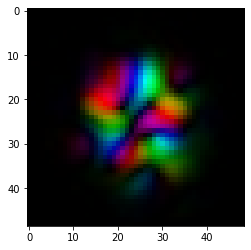

In [46]:
ind_channel = 1


Ein = (Mout.transpose()@v[ind_channel,:]).reshape([N_out]*2)
Eout = (Mout.transpose()@u[:, ind_channel]).reshape([N_out]*2).conjugate()


plt.figure()
plt.imshow(colorize(Eout))


E_out_rm = Ys_rm[ind_step, ind_operator, ind_angle, ind_channel, :].reshape([N_out]*2)

plt.figure()
plt.imshow(colorize(E_out_rm))

In [47]:


plt.figure()
plt.imshow(colorize(E_in_rnd))

AxisError: axis2: axis 2 is out of bounds for array of dimension 2

<Figure size 432x288 with 0 Axes>

In [48]:
def corr(A,B):
    return stack_correlation(A.ravel()[None,...], B.ravel())[0]

../common/functions.py:41: RuntimeWarning: divide by zero encountered in true_divide
  l = 1.0 / (1.0 + r**beta) if theme == "white" else 1.0 - 1.0 / (1.0 + r**beta)


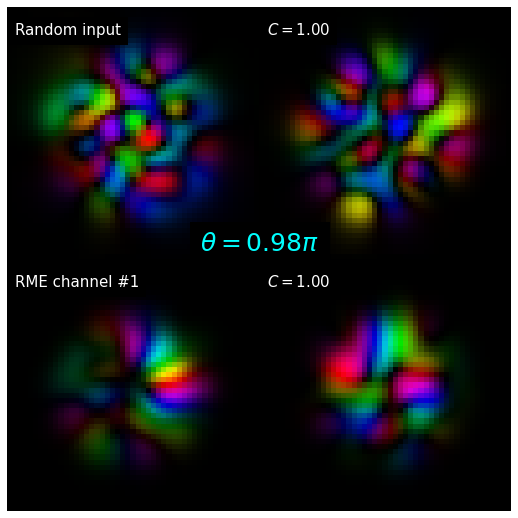

In [50]:
# for i, angle in enumerate(angle2show):
#     plt.subplot(2, 2, i + 1)
#     ind_angle = get_ind_angle(angle)
#     actual_angle = angles[ind_angle]
#     field = Ys_rnd[ind_step, ind_angle, ind_rnd].reshape([N_out] * 2)
#     plt.imshow(colorize(field))
#     plt.axis("off")
#     plt.title(f"$\\theta={actual_angle/np.pi:.2f}\pi$", fontsize=16)
#     plt.suptitle(
#         "Output fields for rotated input, no deformation, random input", fontsize=16
#     )

ind_step = 2
ind_rnd = 0
ind_channel = 1
ind_operator = 2

n_angles = Ys_rnd.shape[1]
angles = np.linspace(0, 2*np.pi, n_angles, endpoint=False)

# Initialize the plot
fig, ax = plt.subplots(figsize = (7, 7))
plt.subplots_adjust(left=0, right=1, top=1, bottom=0)
# field0 = Ys_rnd[ind_step, 0, ind_rnd].reshape([N_out] * 2)

E_in0_c0 = (Mout.transpose()@v[ind_channel,:]).reshape([N_out]*2)
E_out0_c0 = Ys_rm[ind_step, ind_operator, 0, 0, :].reshape([N_out]*2)
E_all_channel_0 = np.vstack((E_in0_c0, E_out0_c0))

E_in0_c1 = (Mout.transpose()@v[ind_channel,:]).reshape([N_out]*2)
E_out0_c1 = Ys_rm[ind_step, ind_operator, 0, 1, :].reshape([N_out]*2)
E_all0_channel_1 = np.vstack((E_in0_c1, E_out0_c1))


E_in_rnd = np.random.rand(nmodes)*np.exp(1j*2*np.pi*np.random.rand(nmodes))
E_in_rnd = Mout.transpose().conjugate()@E_in_rnd
E_in0_rnd = E_in_rnd.reshape([N_out]*2)
E_out0_rnd = Ys_rnd[ind_step, 0, ind_rnd].reshape([N_out] * 2)
E_all0_rnd = np.vstack((E_in0_rnd, E_out0_rnd))

E_all = np.hstack((E_all0_channel_1, E_all0_rnd))

im = ax.imshow(colorize(E_all), animated=True)
ax.axis('off')
ax.set_position([0, 0, 1, 1])



def rotate(E, angle):
    R = get_rotation_matrix(m, l, -angle)
    # print('-'*100)
    # print(E.shape)
    # print(Mout.transpose().shape)
    
    E_rotated = E.ravel()@Mout.transpose().conjugate()@R@Mout
    return E_rotated#.reshape([N_out]*2)

def norm_im(E):
    E = E/np.max(np.abs(E))
    return E.reshape([N_out]*2)



def update(ind_angle):
    
    ##########################
    #### Random input ########
    ##########################

    E_out_rnd = Ys_rnd[ind_step, ind_angle, ind_rnd].reshape([N_out] * 2)
    E_out_rotated = rotate(E_out_rnd, angles[ind_angle])
    E_in_rotated = rotate(E_in0_rnd, angles[ind_angle])

    E_all_rnd = np.vstack((norm_im(E_in_rotated), norm_im(E_out_rotated)))

    Corr = corr(E_out_rnd,E_out0_rnd)
    Corr_txt = rf'$C={Corr:.2f}$'

    plt.text(1, 5, f'Random input', color='white', backgroundcolor='black', fontsize = 15)
    plt.text(N_out+1, 5, Corr_txt, color='white', backgroundcolor='black', fontsize = 15)


    ##########################
    ##### RM channel 1 #######
    ##########################
    E_out_rm = Ys_rm[ind_step, ind_operator, ind_angle, ind_channel, :].reshape([N_out]*2)


    # field = Ys_rnd[ind_step, ind_angle, ind_rnd]
    
    # field_in = Mout.transpose()@v[ind_channel,:]
    E_out_rotated = rotate(E_out_rm, angles[ind_angle])
    # field_rotated = field.reshape
    E_in_rotated = rotate(E_in0_c1, angles[ind_angle])

    Corr = corr(E_out_rm,E_out0_c1)
    Corr_txt = rf'$C={Corr:.2f}$'

    plt.text(1, 5+N_out, f'RME channel #1', color='white', backgroundcolor='black', fontsize = 15)
    plt.text(N_out+1, 5+N_out, Corr_txt, color='white', backgroundcolor='black', fontsize = 15)

    plt.text(N_out-12, N_out-2, rf'$\theta = {angles[ind_angle]/(2*np.pi):.2f}\pi$', color='cyan', backgroundcolor='black', fontsize = 25)
    

    

    E_all_c1 = np.vstack((norm_im(E_in_rotated), norm_im(E_out_rotated)))

    E_all = np.hstack((E_all_rnd, E_all_c1))

    im.set_array(colorize(E_all))
    return [im]

# Create the animation object
ani = FuncAnimation(fig, update, frames=range(n_angles), blit=True)

# Save the animation as an AVI file
ani.save(f'rotation_rnd_VS_rm_dx_{Delta_x[ind_step]:.0f}.avi', writer='ffmpeg', fps=4)


In [ ]:
# # reshape the two last dimensions (2d output plane) into one
# Ys_rnd = Ys_rnd.reshape(n_deform, n_a, n_rnd, N_out**2)


### B. Prepare the data
* Clip with a disk mask
* Remove mean field value (for correlation calculation)
* Change axis order

In [51]:
# create mask to focus on the central part of the output plane
mask_output = (
    get_disk_mask([N_out, N_out], 0.74 * N_out / 2).flatten().astype(np.complex64)
)

# apply mask to the experimental data on the last dimension
Ys_rnd = np.einsum("...i,i->...i", Ys_rnd, mask_output)

# remove the average value (computed over the last dimension)
Ys_rnd -= np.mean(Ys_rnd, axis=-1, keepdims=True)

# move the axis so that the penultimate one corresponds to angles
Ys_rnd = np.moveaxis(Ys_rnd, -3, -2)


In [52]:
# # # # project into the mode basis
# # # It allows much smaller size, so faster computation and use less memory,
# # # but could be done in the spatial basis too)
# Ys_rnd_mode = np.einsum('...i,ji->...j', Ys_rnd, Mout.conjugate())


### C. Compute correlation

In [53]:
# reference fields, i.e. the ones we compare to for the correlation
# with fix the angle vlaue theta to 0
Y_rnd_ref = Ys_rnd[..., 0, :]


In [54]:
Corr_rnd = stack_correlation(Ys_rnd, Y_rnd_ref)


In [55]:
# Average over the realization of random inputs
Corr_rnd_avg = np.mean(Corr_rnd, axis=-2)


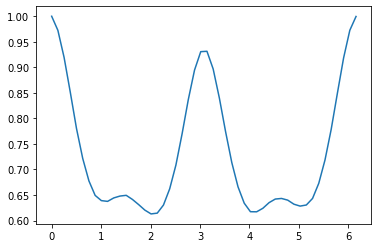

In [56]:
ind_step = 0

plt.figure()
plt.plot(angles, Corr_rnd_avg[ind_step, :])


## III. Computation of angular memory effect correlation for fiber modes as inputs

We here compute from the TM the ouput field when we send as input a mode of the perfect fiber and rotate it.

### A. Compute output for each input fiber mode and each deformation


We apply rotation by an angle $\theta$ at the input plane
and by an angle $-\theta$ in the output plane, so that we have
 $Y=\mathbf{R}(-\theta)\mathbf{T}\mathbf{R}(\theta) E^\text{mode}_\text{in}$

In [57]:
## Rotation matrices for all angles of rotation
R_mats = np.array([get_rotation_matrix(m, l, a) for a in angles]).astype(np.complex64)
## All input modes one by one in the mode basis, i.e. an identity matrix
E_in = np.eye(nmodes, dtype=np.complex64)


Note that in the OAM basis, the rotation operator is represented by a diagonal matrix with unitary modulus elements $\mathbf{R}(\theta)^{-1}$ so that $\mathbf{R}(\theta)^*$, 
thus
```python
    R_inv_mats = R_mats.conjugate()

```

In [60]:
TMs.shape

(5, 55, 55)

In [61]:
# in the OAM mode basis, inverse of R = R.conjugate()
Y_modes = np.einsum(
    # "aij,sjk,akl->slai", R_mats.conjugate(), TMs[deformation_indices, ...], R_mats
    "aij,sjk,akl->slai", R_mats.conjugate(), TMs, R_mats
)
Y_modes_pix = np.einsum("ijkl,lm->ijkm", Y_modes, Mout)


In [62]:
# the reference field for the corrtelation correspond to the angle \theta = 0
Y_modes_ref = Y_modes[..., 0, :]


### B. Display the output field for a given input mode and deformation value

(-0.5, 48.5, 48.5, -0.5)

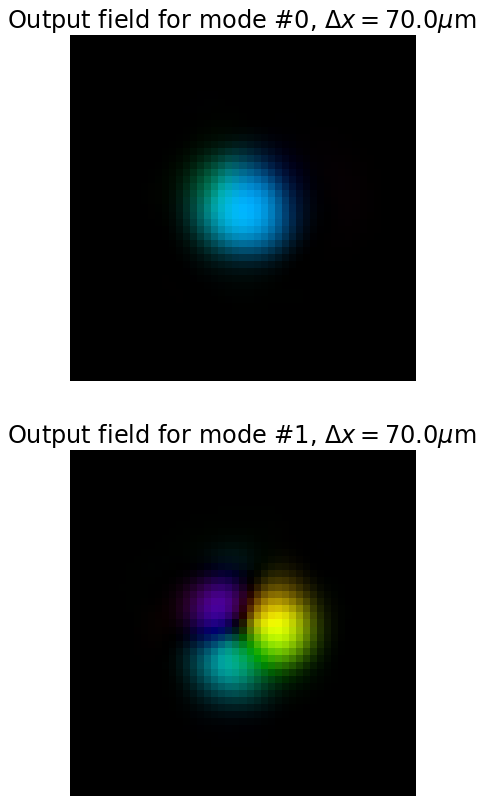

In [64]:
ind_step = -1
ind_mode = 0
plt.figure(figsize=(7, 14))
plt.subplot(211)
plt.imshow(colorize(Y_modes_pix[ind_step, ind_mode, 0].reshape([N_out] * 2)))
plt.title(
    f"Output field for mode #{ind_mode}, $\Delta x = {Delta_x[ind_step]:.1f}\mu$m ",
    fontsize=TITLE_SIZE,
)
plt.axis("off")
plt.subplot(212)
plt.imshow(colorize(Y_modes_pix[ind_step, ind_mode+1, 0].reshape([N_out] * 2)))
plt.title(
    f"Output field for mode #{ind_mode+1}, $\Delta x = {Delta_x[ind_step]:.1f}\mu$m ",
    fontsize=TITLE_SIZE,
)
plt.axis("off")


### C. Compute correlation between all angles and angle = 0 for all the parameters

In [65]:
Corr_modes = stack_correlation(Y_modes, Y_modes_ref)


### D. Show the RME correlation for different deformation and different fiber modes as input

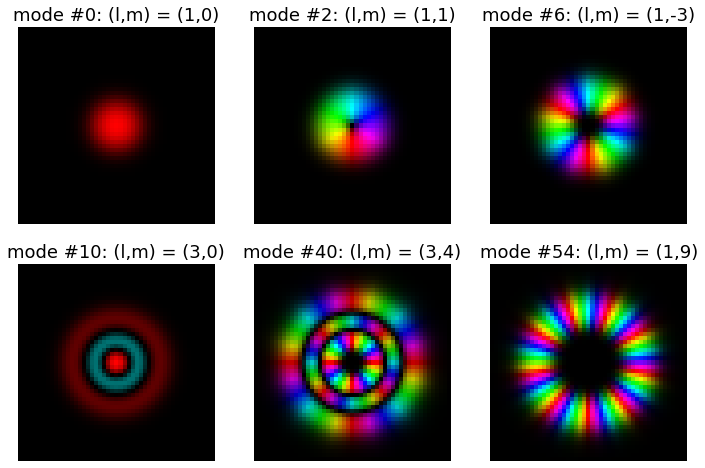

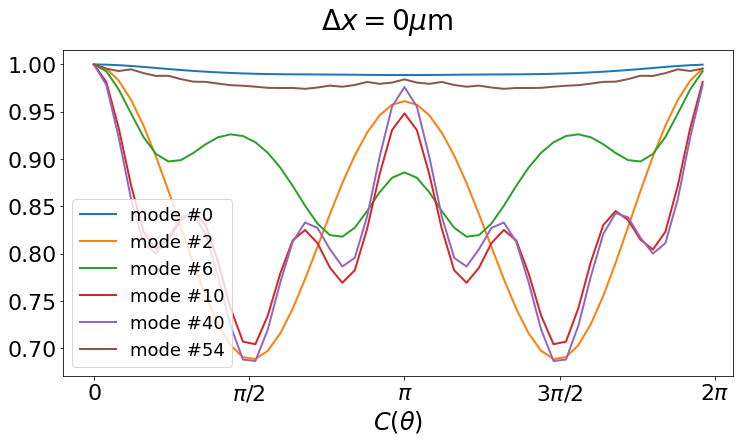

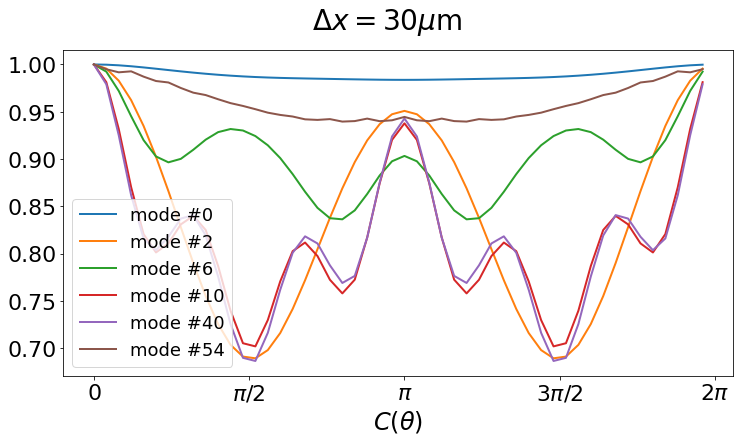

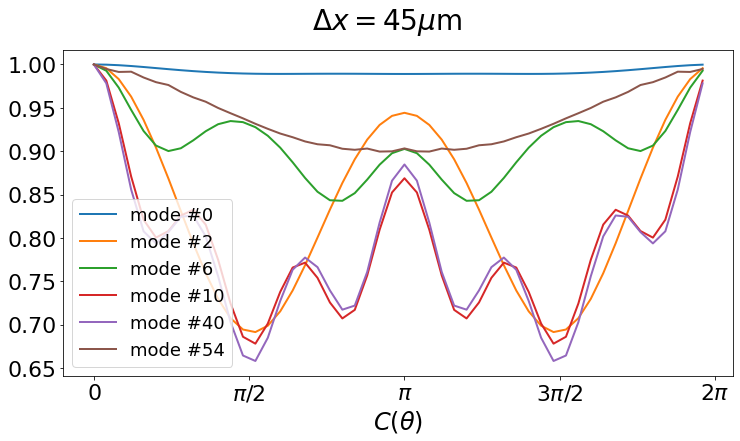

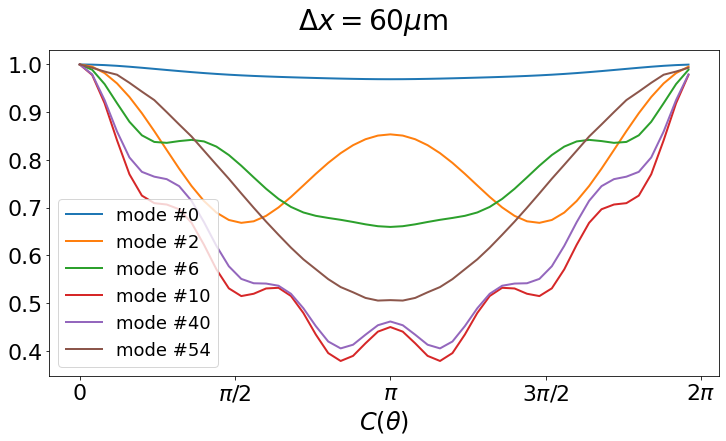

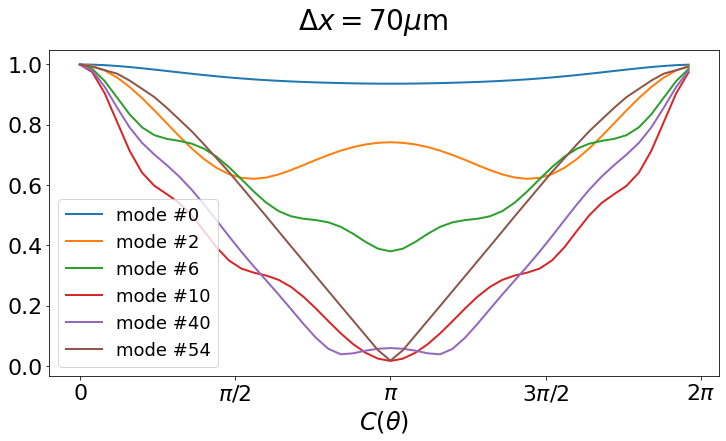

In [67]:
modes2show = [0, 2, 6, 10, 40, 54]


plt.figure(figsize=(12, 8))
for i, ind_mode in enumerate(modes2show):
    plt.subplot(2, 3, i + 1)
    plt.imshow(colorize(Mout[ind_mode].reshape([N_out] * 2)))
    plt.axis("off")
    plt.title(
        f"mode #{ind_mode}: (l,m) = ({l[ind_mode]},{m[ind_mode]})",
        fontsize=TINY_TITLE_SIZE,
    )


def show_RME_modes(ind_deformation):
    plt.figure(figsize=(12, 6))
    for ind_mode in modes2show:
        plt.plot(
            angles,
            Corr_modes[ind_deformation, ind_mode, :],
            linewidth=2,
            label=f"mode #{ind_mode}",
        )
    plt.xlabel(r"$\theta$", fontsize=LABEL_SIZE)
    plt.xlabel(r"$C(\theta)$", fontsize=LABEL_SIZE)
    xticks = [0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi]
    xtics_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]
    plt.xticks(xticks, xtics_labels, fontsize=TICK_SIZE)
    plt.yticks(fontsize=TICK_SIZE)
    plt.legend(fontsize=LEGEND_SIZE)
    plt.suptitle(
        f"$\Delta x = {Delta_x[ind_deformation]:.0f} \mu$m", fontsize=SUP_TITLE_SIZE
    )


for ind_deformation in range(n_deform):
    show_RME_modes(ind_deformation)


### E. Show the minimum of the correlation curve for each mode for different deformations

Text(0.5, 1.0, 'RME efficiency of the fibers modes')

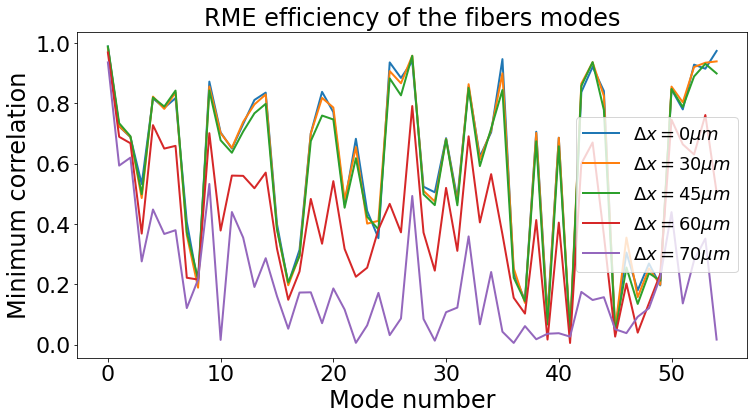

In [68]:
min_Corr_modes = np.min(Corr_modes, axis=-1)


plt.figure(figsize=(12, 6))
for Dx, min_Corr_mode in zip(Delta_x, min_Corr_modes):
    plt.plot(min_Corr_mode, label=rf"$\Delta x = {Dx:.0f}\mu m$", linewidth=2)
plt.xlabel("Mode number", fontsize=LABEL_SIZE)
plt.xticks(fontsize=TICK_SIZE)
plt.ylabel("Minimum correlation", fontsize=LABEL_SIZE)
plt.yticks(fontsize=TICK_SIZE)

plt.legend(fontsize=LEGEND_SIZE)
plt.title("RME efficiency of the fibers modes", fontsize=TITLE_SIZE)


# III. RME Operator

## A. Computation of correlation for the modes of the RME operators

**Operators:** $\mathbf{O}(\theta) = \mathbf{T}^\dagger\mathbf{R(\theta)}^\dagger\mathbf{T}\mathbf{R(\theta)}$
1.  $\mathbf{O}(\theta = \pi/2)$
2.  $\mathbf{O}(\theta = 3\pi/2)$
3.  $\mathbf{O}(\theta = \pi/2)+\mathbf{O}(\theta = \pi)+\mathbf{O}(\theta = 3\pi/2)$

In [69]:
label_operators = [
    r"$\hat O_{corr} (\pi /2) $",
    r"$\hat O_{corr} (3\pi /2) $",
    r"$\sum \hat O_{corr} $",
]


In [70]:
# move axis for the penultimate dimension to be the angle
# Ys_rm = np.moveaxis(Ys_rm, -3, -2)


`Ys_rm`: [deformation $\times$ operator $\times$ mode $\times$ angles $\times$ Nx $\times$ Ny]

In [71]:
Ys_rm_ref = Ys_rm[..., 0, :, :]


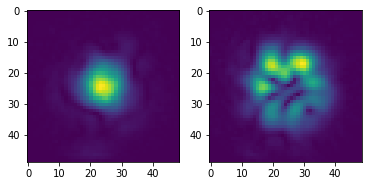

In [72]:

plt.figure()
plt.subplot(121)
plt.imshow(np.abs(Ys_rm[0,0,0,0]).reshape([N_out]*2))
plt.subplot(122)
plt.imshow(np.abs(Ys_rm[0,0,0,1]).reshape([N_out]*2))

### Compute correlation using the RME operator singular vector as input using experimental measurement

In [73]:
Ys_rm = np.moveaxis(Ys_rm, -3, -2)
Corr_rnd = stack_correlation(Ys_rm, Ys_rm_ref)


In [83]:
def generate_color_shades(color, n):
    # Generate a list of `n` different shades of the given color
    cmap = plt.get_cmap(color)
    dc = 100
    shades = [cmap(int(dc + i * (255 - dc) / (n - 1))) for i in range(n)]
    return shades[::-1]


n = 4  # Number of shades

# Generate lists of shades for blue, red, and green
shades = [
    generate_color_shades("PuRd", n),
    generate_color_shades("Blues", n),
    generate_color_shades("Greens", n),
]


def show_RME_operator(ind_deformation, inds_operator, inds_mode, save_fig=True):
    plt.figure(figsize=(12, 6))

    # plot the modes of the correlation operators
    for i_operator, ind_operator in enumerate(inds_operator):
        for i_mode, ind_mode in enumerate(inds_mode):
            plt.plot(
                angles,
                Corr_rnd[ind_deformation, ind_operator, ind_mode, :],
                linewidth=2,
                label=f"{label_operators[ind_operator]} #{ind_mode+1}",
                c=shades[i_operator][i_mode],
            )

    # plot the random inputs
    ind_mode = 0
    plt.plot(
        angles,
        Corr_rnd_avg[ind_deformation, :],
        "r--",
        linewidth=2,
        label=f"random inputs",
    )

    # plot average for fundamental mode
    ind_mode = 0
    plt.plot(
        angles,
        Corr_modes[ind_deformation, ind_mode, :],
        "k--",
        linewidth=2,
        label="fundamental mode",
    )

    # plt.grid()
    plt.xlabel(r"$\theta$", fontsize=LABEL_SIZE)
    plt.ylabel(r"$C(\theta)$", fontsize=LABEL_SIZE)
    xticks = [0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi]
    xtics_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]
    plt.xticks(xticks, xtics_labels, fontsize=LABEL_SIZE)
    plt.yticks(fontsize=LABEL_SIZE)
    plt.legend(fontsize=LEGEND_SIZE)
    plt.suptitle(
        f"$\Delta x = {Delta_x[ind_deformation]:.0f} \mu$m", fontsize=SUP_TITLE_SIZE
    )

    if save_fig:
        plt.savefig(
            image_path(f"Corr_rnd_{Delta_x[ind_deformation]:.0f}um.svg"),
            dpi=300,
        )


In [84]:
def show_operator_modes(ind_deformation, operators, ind_modes, save_fig=True):
    plt.figure(figsize=(7, 7))
    ind_angle = 0
    theme = "white"
    toimg = lambda A: colorize(A.reshape([N_out] * 2), theme=theme, alpha=0.0)

    ind_mode = ind_modes[0]

    plt.subplot(221)
    plt.imshow(toimg(Ys_rm[ind_deformation, operators[0], ind_mode, ind_angle, ...]))
    plt.title(f"{label_operators[operators2show[0]]} #{ind_mode+1}")
    plt.axis("off")
    plt.subplot(222)
    plt.imshow(toimg(Ys_rm[ind_deformation, operators[1], ind_mode, ind_angle, ...]))
    plt.title(f"{label_operators[operators2show[1]]} #{ind_mode+1}")
    plt.axis("off")

    ind_mode = ind_modes[1]

    plt.subplot(223)
    plt.imshow(toimg(Ys_rm[ind_deformation, operators[0], ind_mode, ind_angle, ...]))
    plt.title(f"{label_operators[operators2show[0]]} #{ind_mode+1}")
    plt.axis("off")
    plt.subplot(224)
    plt.imshow(toimg(Ys_rm[ind_deformation, operators[1], ind_mode, ind_angle, ...]))
    plt.title(f"{label_operators[operators2show[1]]} #{ind_mode+1}")
    plt.axis("off")

    if save_fig:
        plt.savefig(
            image_path(f"RME_modes_{Delta_x[ind_deformation]:.0f}um.svg"),
            dpi=300,
        )


>> image path: ../images/Draka_GRIN/Corr_rnd_0um.svg
>> image path: ../images/Draka_GRIN/RME_modes_0um.svg
>> image path: ../images/Draka_GRIN/Corr_rnd_30um.svg
>> image path: ../images/Draka_GRIN/RME_modes_30um.svg
>> image path: ../images/Draka_GRIN/Corr_rnd_45um.svg
>> image path: ../images/Draka_GRIN/RME_modes_45um.svg
>> image path: ../images/Draka_GRIN/Corr_rnd_60um.svg
>> image path: ../images/Draka_GRIN/RME_modes_60um.svg
>> image path: ../images/Draka_GRIN/Corr_rnd_70um.svg
>> image path: ../images/Draka_GRIN/RME_modes_70um.svg


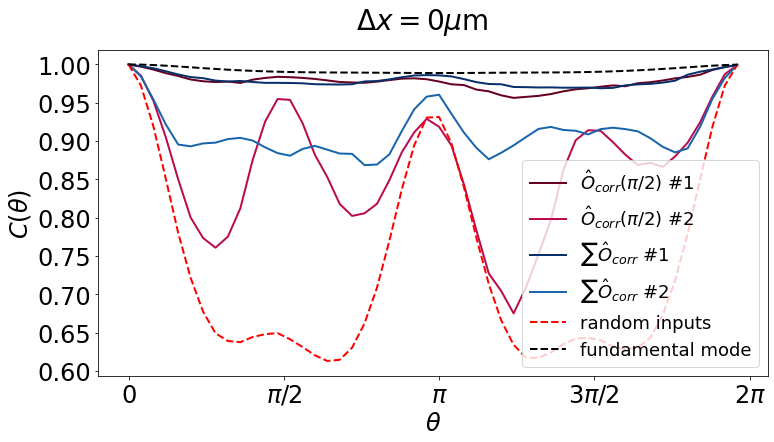

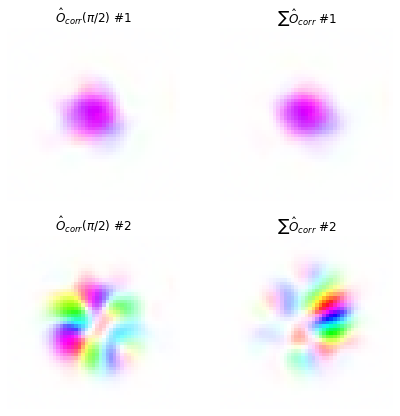

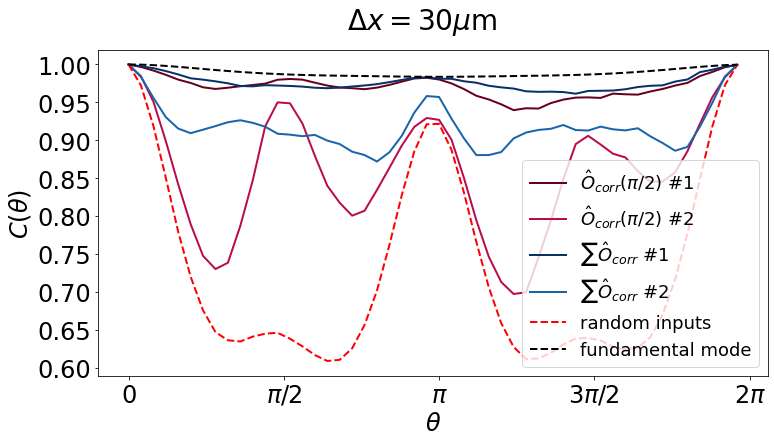

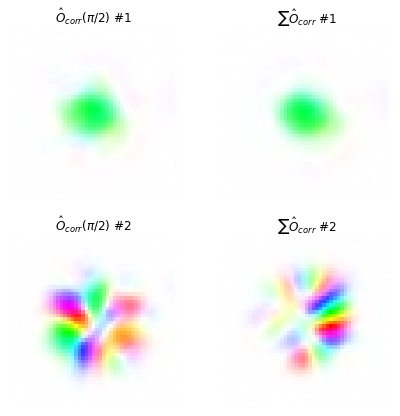

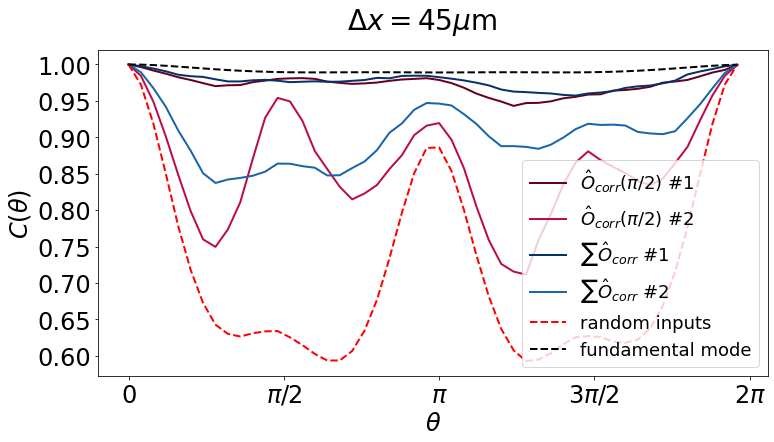

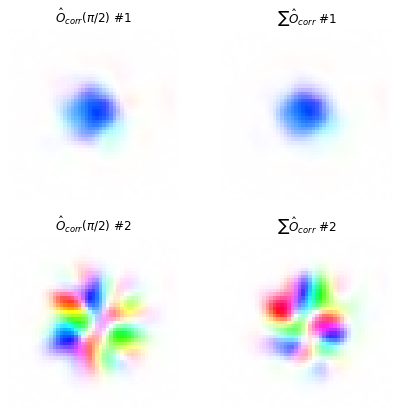

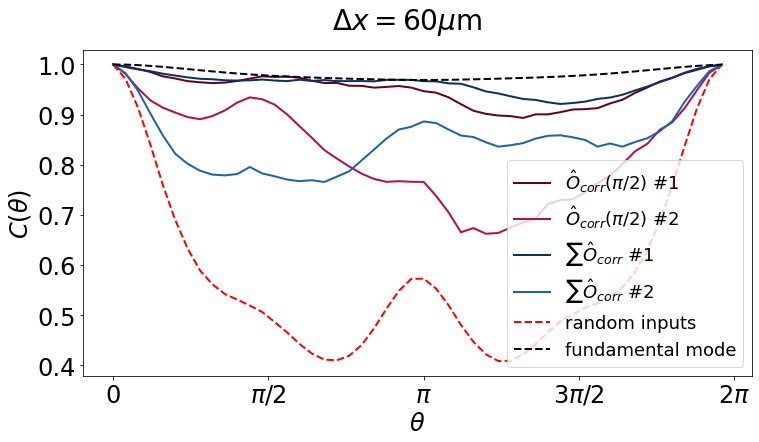

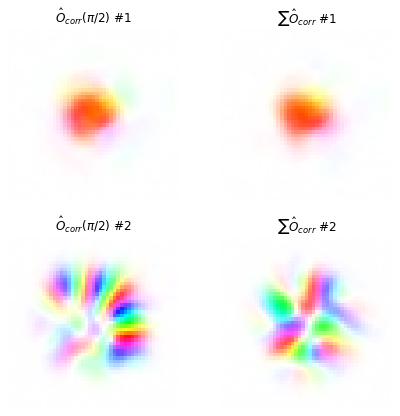

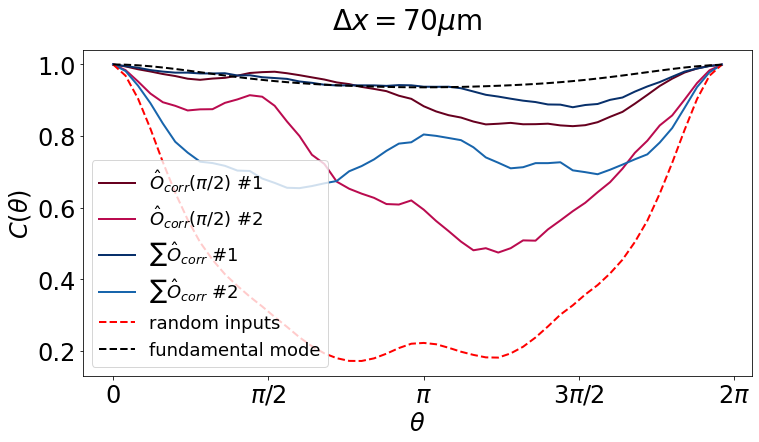

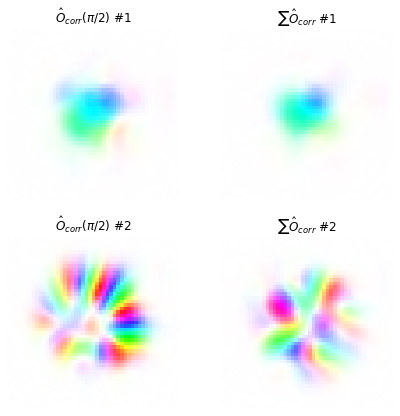

In [85]:
operators2show = [0, 2]
modes2show = [0, 1]
ind_angle = 0
ind_deformation, ind_operator, ind_mode = 0, 0, 0
for ind_deformation in range(n_deform):
    show_RME_operator(
        ind_deformation,
        operators2show,
        modes2show,
    )

    show_operator_modes(
        ind_deformation,
        operators2show,
        modes2show,
    )


### B. Autocorrelation of the RME channels

$$
C_0(\theta) =  
    \left|
    \frac{
        \bra{\phi}\mathbf{T}^\dagger\mathbf{R(\theta)}^\dagger\mathbf{T}\ket{\phi}
    }{
            \bra{\phi}\mathbf{T}^\dagger\mathbf{T}\ket{\phi}        
    }
    \right|
$$

In [133]:
# project the output fields for random inputs into the mode basis
Ys_rnd_mode = np.einsum('...x, xn -> ...n', Ys_rnd, Mout.transpose().conjugate())

print(Ys_rnd_mode.shape)

(5, 100, 50, 2401)
(5, 100, 50, 55)


In [146]:
def get_autocorr(Y0_mode):
    
    ind_angle_ref = 0
    Y0_mode = Y0_mode[:,:, ind_angle_ref, ...]
    # project into mode basis
    # Y0_mode = np.einsum('ij,...j->...i', Mout.conjugate(), Y0)
    # rotate the patterns
    # Ys_rm[ind_deformation, operators[0], ind_mode, ind_angle, ...]
    Y0_rot = np.einsum("aij,...j->...ai", R_mats, Y0_mode)
    Y0_autocorr_ref = Y0_rot[..., 0, :]
    Autocorr_op = stack_correlation(Y0_rot, Y0_autocorr_ref)
    return Autocorr_op


In [151]:
# autocorrelation of the RME channels
Autocorr_op = get_autocorr(Ys_rm_mode)
# autocorrelation of the fiber modes
Autocorr_modes = get_autocorr(Y_modes)
# autocorrelation of the output for random inputs
Autocorr_rnd = get_autocorr(Ys_rnd_mode).mean(axis = 1)


In [140]:
A = Ys_rm_mode@Mout
Y_modes.shape

(5, 55, 50, 55)

In [152]:
Autocorr_rnd.shape

(5, 50)

In [145]:
Ys_rnd_mode.shape

(5, 100, 50, 55)

>> image path: ../images/Draka_GRIN/Autocorr_op_channels_0um.svg
>> image path: ../images/Draka_GRIN/Autocorr_op_channels_30um.svg
>> image path: ../images/Draka_GRIN/Autocorr_op_channels_45um.svg
>> image path: ../images/Draka_GRIN/Autocorr_op_channels_60um.svg
>> image path: ../images/Draka_GRIN/Autocorr_op_channels_70um.svg


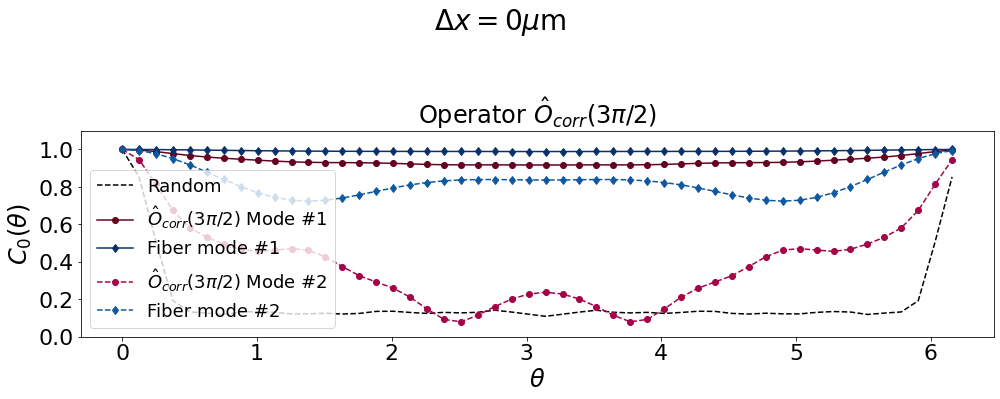

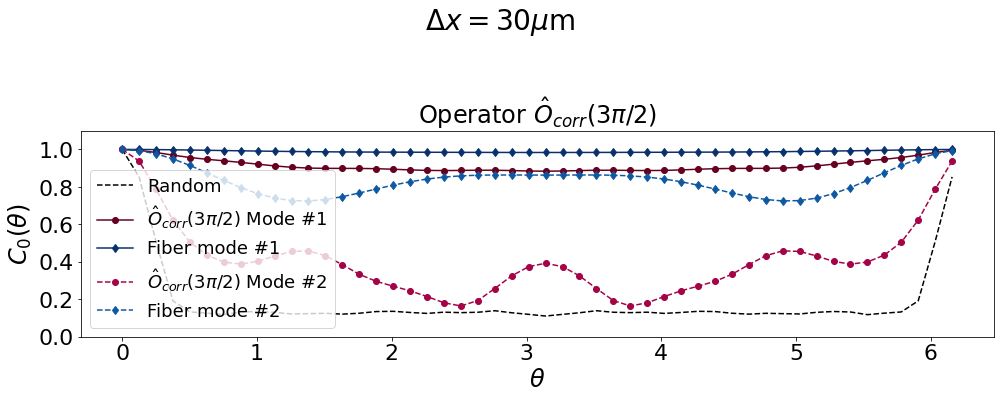

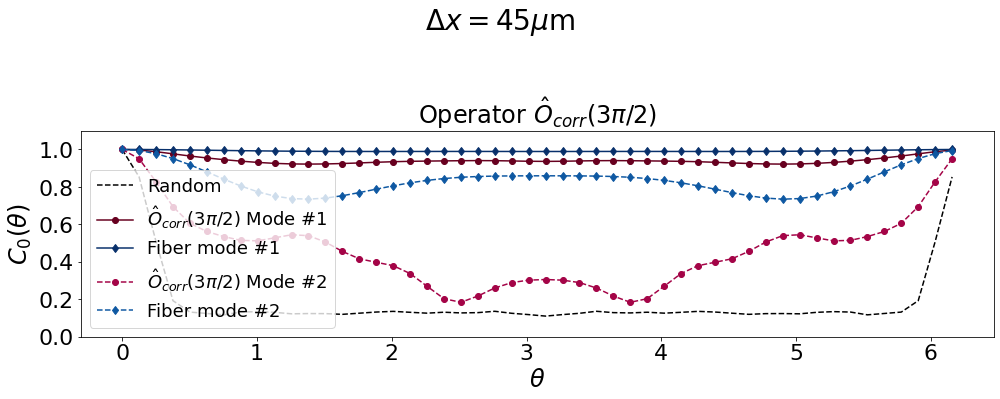

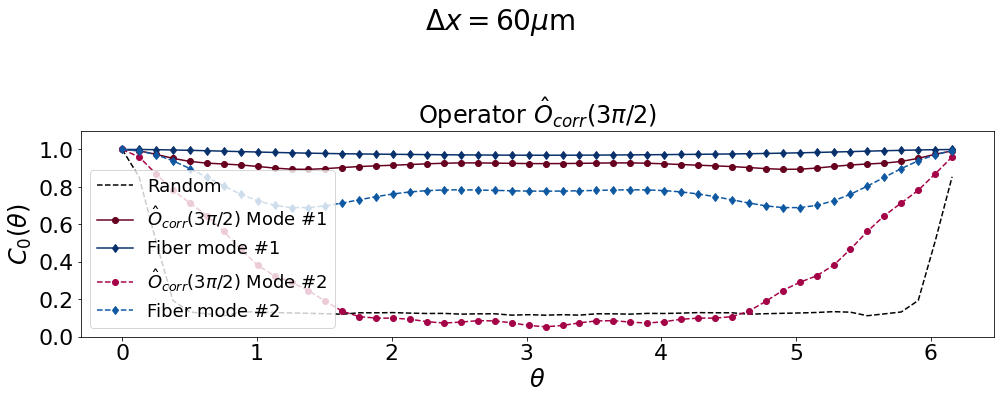

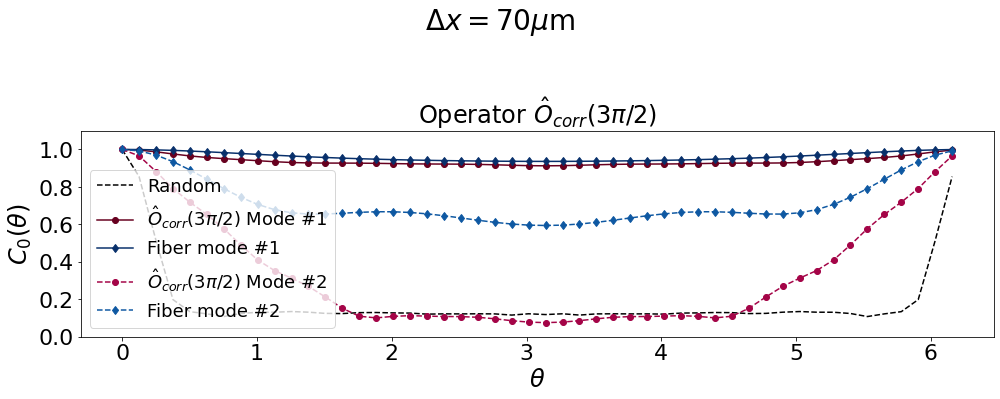

In [153]:
ind_deformation = 0
ind_operator = 0
ind_op_mode = 1
ind_fiber_mode = 0

linestyles = ["solid", "dashed", "dotted", "dashdot"]


def show_autocorr(
    ind_deformation, operators2show, ind_angle, modes2show, save_fig=True
):

    plt.figure(figsize=(14, 5))
    plt.plot(
        angles,
        np.abs(Autocorr_rnd[ind_deformation]) ,
        color='black',
        label=f"Random",
        linestyle="dashed",
    )
    for i_operator, ind_operator in enumerate(operators2show):
        for i_mode, ind_mode in enumerate(modes2show):
            plt.subplot(1, len(operators2show), i_operator + 1)
            plt.plot(
                angles,
                np.abs(Autocorr_op[ind_deformation, ind_operator, ind_mode, :]) ,
                color=shades[0][i_mode],
                label=f"{label_operators[ind_operator]} Mode #{ind_mode+1}",
                marker="o",
                linestyle=linestyles[i_mode],
            )
            plt.plot(
                angles,
                np.abs(Autocorr_modes[ind_deformation, ind_mode, :]),
                color=shades[1][i_mode],
                label=f"Fiber mode #{ind_mode+1}",
                marker="d",
                linestyle=linestyles[i_mode],
            )
            plt.ylim([0, 1.1])
            plt.legend(fontsize=LEGEND_SIZE)
            plt.xticks(fontsize=TICK_SIZE)
            plt.xlabel(r"$\theta$", fontsize=LABEL_SIZE)
            plt.yticks(fontsize=TICK_SIZE)
            plt.ylabel(r"$C_0(\theta)$", fontsize=LABEL_SIZE)
            plt.title(f"Operator {label_operators[ind_operator]}", fontsize=TITLE_SIZE)

        plt.suptitle(
            f"$\Delta x = {Delta_x[ind_deformation]:.0f} \mu$m",
            fontsize=SUP_TITLE_SIZE,
            y=1.1,
        )

    plt.tight_layout()
    if save_fig:
        plt.savefig(
            image_path(f"Autocorr_op_channels_{Delta_x[ind_deformation]:.0f}um.svg"),
            dpi=300,
        )


for ind_deformation in range(n_deform):
    show_autocorr(
        ind_deformation,
        operators2show,
        ind_angle,
        modes2show,
    )


>> image path: ../images/Draka_GRIN/Autocorr_op_channels_0um.svg
>> image path: ../images/Draka_GRIN/Autocorr_op_channels_30um.svg
>> image path: ../images/Draka_GRIN/Autocorr_op_channels_45um.svg
>> image path: ../images/Draka_GRIN/Autocorr_op_channels_60um.svg
>> image path: ../images/Draka_GRIN/Autocorr_op_channels_70um.svg


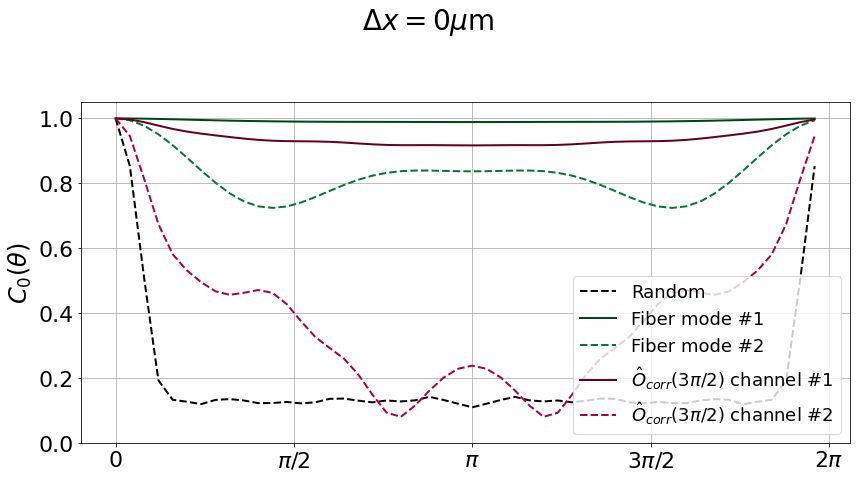

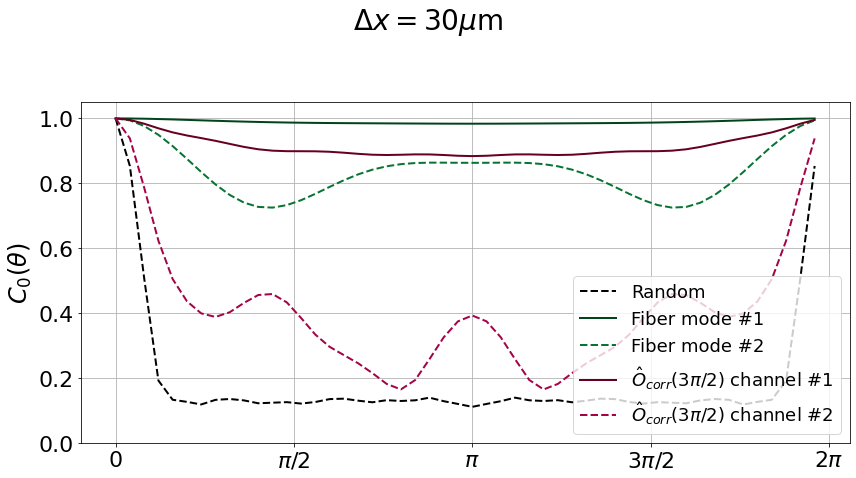

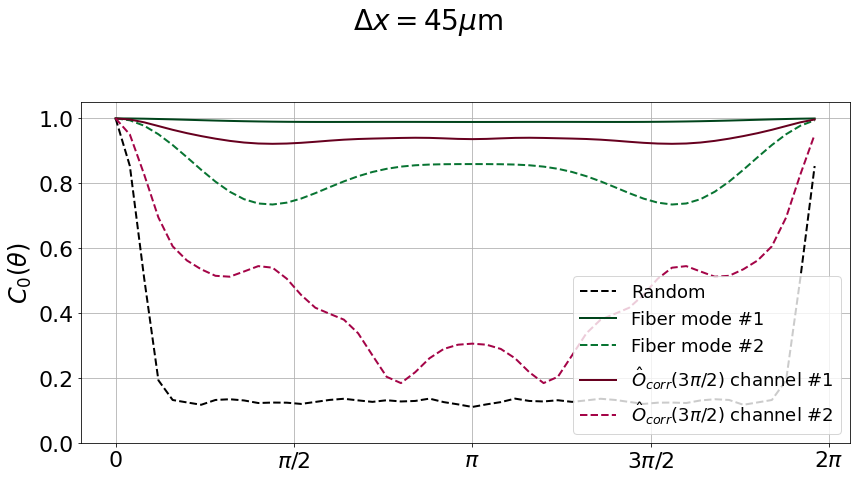

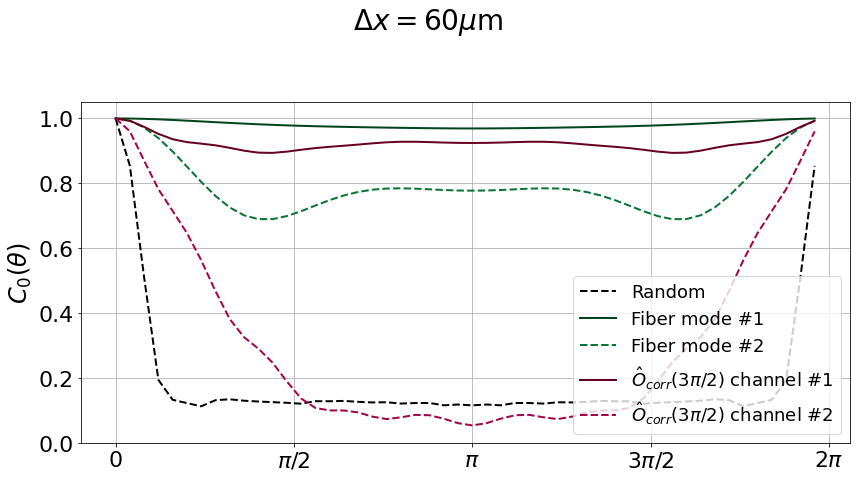

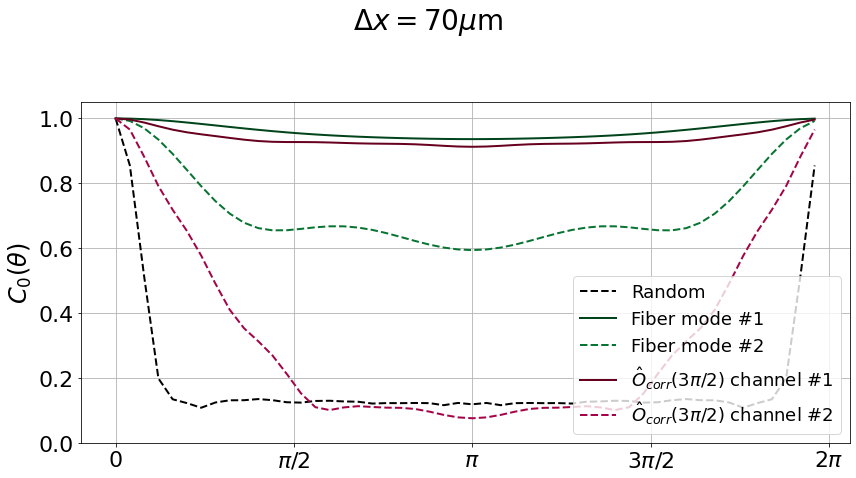

In [155]:
ind_deformation = 0
ind_operator = 0
ind_op_mode = 1
ind_fiber_mode = 0

linestyles = ["solid", "dashed", "dotted", "dashdot"]

modes2show = [0,1]
operators2show = [1]


def show_autocorr(
    ind_deformation, operators2show, ind_angle, modes2show, save_fig=True
):

    plt.figure(figsize=(12, 6))
    plt.grid()
    plt.plot(
        angles,
        np.abs(Autocorr_rnd[ind_deformation]) ,
        color='black',
        label=f"Random",
        linestyle="dashed",
        linewidth=2,
    )
    for i_mode, ind_mode in enumerate(modes2show):

        plt.plot(
            angles,
            np.abs(Autocorr_modes[ind_deformation, ind_mode, :]) ,
            color=shades[2][i_mode],
            label=f"Fiber mode #{ind_mode+1}",
            # marker = 'd',
            linestyle=linestyles[i_mode],
            linewidth=2,
        )
    for i_operator, ind_operator in enumerate(operators2show):
        for i_mode, ind_mode in enumerate(modes2show):

            plt.plot(
                angles,
                np.abs(Autocorr_op[ind_deformation, ind_operator, ind_mode, :]) ,
                color=shades[i_operator][i_mode],
                label=f"{label_operators[ind_operator]} channel #{ind_mode+1}",
                # marker = 'o',
                linestyle=linestyles[i_mode],
                linewidth=2,
            )

            plt.ylim([0, 1.05])
            plt.legend(fontsize=LEGEND_SIZE, loc="lower right")
            xticks = [0, np.pi / 2, np.pi, 3 * np.pi / 2, 2 * np.pi]
            xtics_labels = [r"$0$", r"$\pi/2$", r"$\pi$", r"$3\pi/2$", r"$2\pi$"]
            plt.xticks(xticks, xtics_labels, fontsize=TICK_SIZE)
            plt.yticks(fontsize=TICK_SIZE)
            plt.ylabel(r"$C_0(\theta)$", fontsize=LABEL_SIZE)
            # plt.title(f'Operator {label_operators[ind_operator]}', fontsize = label_size+2)

        plt.suptitle(
            f"$\Delta x = {Delta_x[ind_deformation]:.0f} \mu$m",
            fontsize=SUP_TITLE_SIZE,
            y=1.1,
        )

    plt.tight_layout()
    if save_fig:
        plt.savefig(
            image_path(f"Autocorr_op_channels_{Delta_x[ind_deformation]:.0f}um.svg"),
            dpi=300,
        )


for ind_deformation in range(n_deform):
    show_autocorr(
        ind_deformation,
        operators2show,
        ind_angle,
        modes2show,
    )


### C. Projection in the mode basis

In [95]:
ind_deformation = 0
operators2show = [0, 2]
modes2show = [0, 1]
ind_angle = 0

Mode_proj = np.abs(
    np.einsum(
        "ij,...j->...i",
        Mout.conjugate(),
        Ys_rm,  # flatten the last two spatial dimensions
    )
)
# normalize the projection
Mode_proj = Mode_proj / np.linalg.norm(Mode_proj, axis=-1)[..., None]


>> image path: ../images/Draka_GRIN/Proj_op_channels_0um.svg
>> image path: ../images/Draka_GRIN/Proj_op_channels_30um.svg
>> image path: ../images/Draka_GRIN/Proj_op_channels_45um.svg
>> image path: ../images/Draka_GRIN/Proj_op_channels_60um.svg
>> image path: ../images/Draka_GRIN/Proj_op_channels_70um.svg


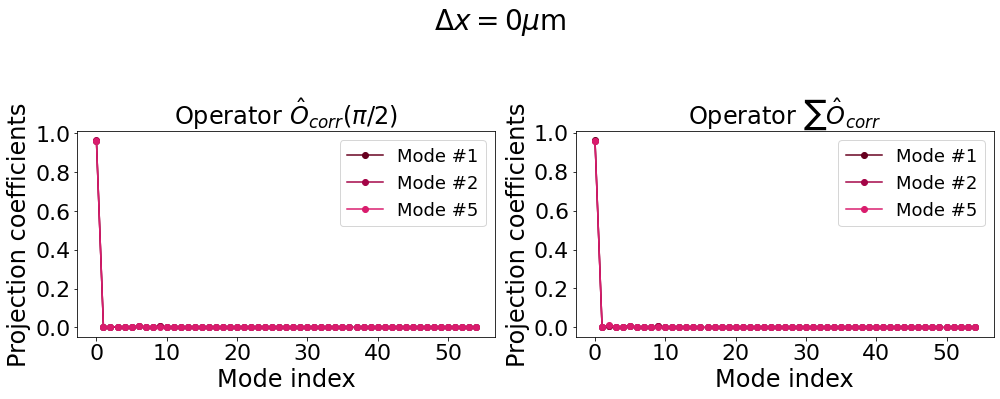

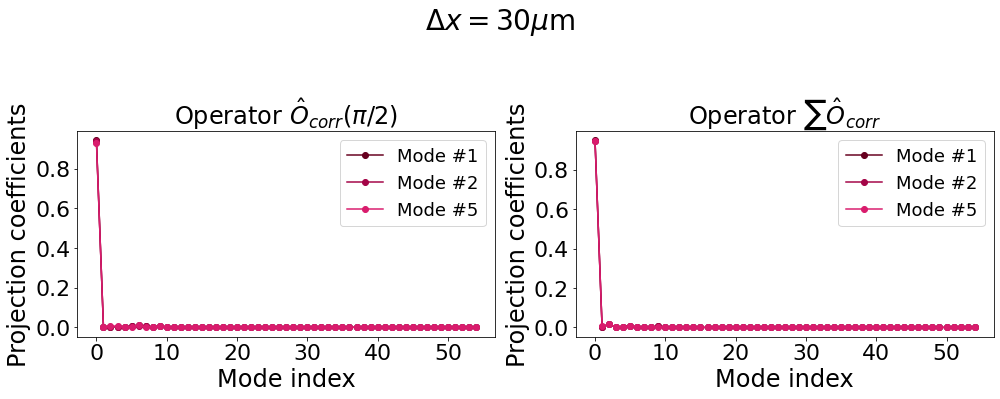

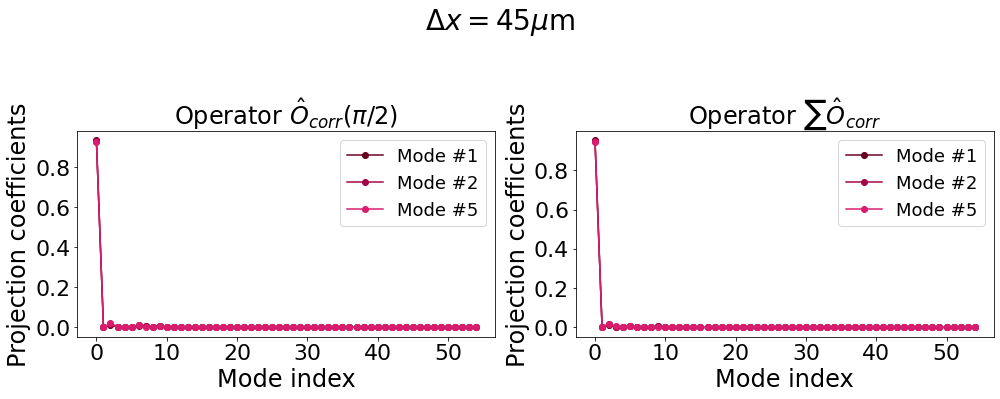

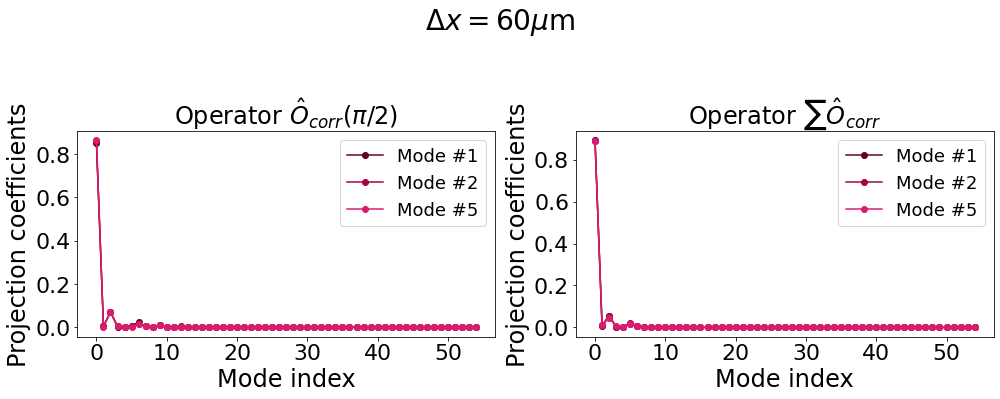

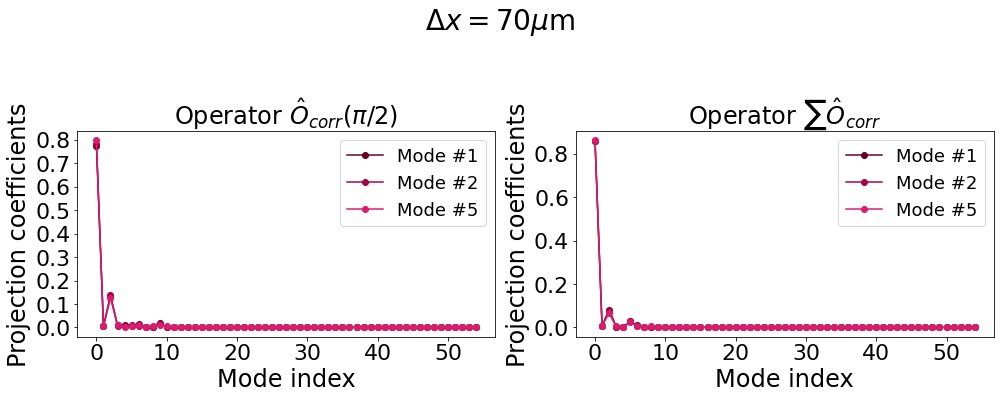

In [96]:
ind_deformation = 0
ind_operator = 0
ind_angle = 0
ind_mode = 0

modes2show = [0, 1, 4]
operators2show = [0, 2]

n = int(len(modes2show) * 1.75)
shades = [
    generate_color_shades("PuRd", n),
    generate_color_shades("Blues", n),
    generate_color_shades("Greens", n),
]


def show_projection(
    ind_deformation, operators2show, ind_angle, modes2show, save_fig=True
):
    plt.figure(figsize=(14, 5))
    for i_operator, ind_operator in enumerate(operators2show):
        for i_mode, ind_mode in enumerate(modes2show):
            plt.subplot(1, len(operators2show), i_operator + 1)
            plt.plot(
                np.abs(Mode_proj[ind_deformation, ind_operator, ind_angle, ind_mode, :])
                ** 2,
                color=shades[0][i_mode],
                label=f"Mode #{ind_mode+1}",
                marker="o",
            )
            plt.legend(fontsize=LEGEND_SIZE)
            plt.xticks(fontsize=TICK_SIZE)
            plt.xlabel("Mode index", fontsize=LABEL_SIZE)
            plt.yticks(fontsize=TICK_SIZE)
            plt.ylabel("Projection coefficients", fontsize=LABEL_SIZE)
            plt.title(f"Operator {label_operators[ind_operator]}", fontsize=TITLE_SIZE)
    plt.suptitle(
        f"$\Delta x = {Delta_x[ind_deformation]:.0f} \mu$m",
        fontsize=SUP_TITLE_SIZE,
        y=1.1,
    )

    plt.tight_layout()
    if save_fig:
        plt.savefig(
            image_path(f"Proj_op_channels_{Delta_x[ind_deformation]:.0f}um.svg"),
            dpi=300,
        )


for ind_deformation in range(n_deform):
    show_projection(
        ind_deformation,
        operators2show,
        ind_angle,
        modes2show,
    )
